In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
class layer_dense:
    'Neural network dense layer'
    
    # initialization (weights and biases)
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons) 
        self.biases = np.zeros((1,n_neurons))

    # output
    def forward(self, inputs):
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
      
    def backward(self, dvalues):
        
        # gradient
        self.dinputs = dvalues.dot(self.weights.T)
        
        # Gradients on parameters
        self.dweights = self.inputs.T.dot(dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        
class activation_ReLU:
    'rectified linear unit activation function'
    
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dvalues):

        # copy dvalues
        self.dinputs = dvalues.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
class activation_softmax:
    'softmax activation function'
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dvalues):

        
        # initialized gradient (derivative) array
        self.dinputs = np.zeros(dvalues.shape)
        
        # For each data point, compute gradient
        for i in range(len(dvalues)):
            output_row = self.output[i]
            dvalues_row = dvalues[i]
            
            # Flatten output array
            output_row = output_row.reshape(-1, 1)

            # Calculate derivative matrix of the output
            derivative_matrix = np.diagflat(output_row) - output_row.dot(output_row.T)
            
            # store gradient
            self.dinputs[i] = dvalues_row.dot(derivative_matrix)


class loss:
    def calculate(self, output,y):
        sample_losses = self.forward(output,y)
        loss = np.mean(sample_losses)
        return loss
    
# cross-entropy loss        
class loss_crossentropy(loss):
    
    def forward(self, y_pred, y_true):
        
        # number of data points
        n_samples = len(y_pred)
        
        # clip data to prevent division by 0
        y_pred_clipped = np.clip(y_pred, 1e-7,1 - 1e-7)
        
        # confidence values
        confidence_values = y_pred_clipped[range(n_samples),y_true]
       
        # sample losses 
        losses = -np.log(confidence_values)
        return losses
    
    
    def backward(self, dvalues, y_true):
        
        
        # Number of samples
        n_samples = len(dvalues)
    
        #one-hot matrix
        Y = np.zeros(dvalues.shape)
        Y[np.arange(len(y_true)),y_true] = 1
        
        # Calculate gradient
        self.dinputs = -Y / dvalues
        
        # Normalize gradient
        self.dinputs = self.dinputs / n_samples
        
# SGD optimizer
class optimizer_SGD:

    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases

In [29]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/fashion-mnist_train.csv'
data = pd.read_csv(url)

In [30]:
y = data.label.to_numpy() # labels 
X = data.iloc[:,1:785].to_numpy() # pixels

In [31]:
X.shape

(5000, 784)

In [89]:
# neural network 
layer1 = layer_dense(n_inputs = 784, n_neurons = 64)
activation1 = activation_ReLU()
layer2 = layer_dense(n_inputs = 64, n_neurons = 64)
activation2 = activation_ReLU()
layer3 = layer_dense(n_inputs = 64, n_neurons = 10)
activation3 = activation_softmax()
loss_function = loss_crossentropy()

In [90]:
# optimizer
optimizer = optimizer_SGD(learning_rate=0.1)

In [96]:
n_epochs = 1000
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    
    # loss
    losses = loss_function.forward(activation3.output,y)
    loss[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation3.output,axis=1)
    accuracy[i] = 100*np.sum(y_pred == y)/len(y)
    
    # backward pass
    loss_function.backward(activation3.output,y)
    activation3.backward(loss_function.dinputs)
    layer3.backward(activation3.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    
    # update weights and biases
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)

    
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss[i],3)))
        print('accuracy: '+str(accuracy[i]))
        print('------------------------')

epoch: 0
loss: 1.791
accuracy: 31.64
------------------------
epoch: 100
loss: 1.779
accuracy: 31.72
------------------------
epoch: 200
loss: 1.769
accuracy: 32.28
------------------------
epoch: 300
loss: 1.759
accuracy: 33.1
------------------------
epoch: 400
loss: 1.75
accuracy: 34.08
------------------------
epoch: 500
loss: 1.741
accuracy: 35.04
------------------------
epoch: 600
loss: 1.731
accuracy: 36.3
------------------------
epoch: 700
loss: 1.72
accuracy: 37.54
------------------------
epoch: 800
loss: 1.709
accuracy: 38.5
------------------------
epoch: 900
loss: 1.698
accuracy: 42.34
------------------------


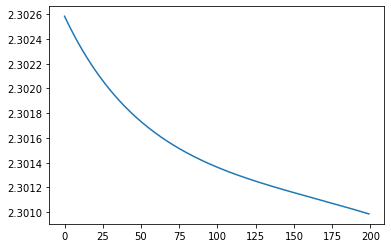

In [93]:
plt.plot(loss)

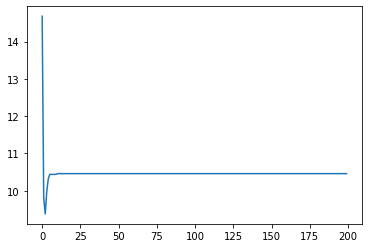

In [94]:
plt.plot(accuracy)

In [78]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/fashion-mnist_test.csv'
data_test = pd.read_csv(url)

In [79]:
y_test = data_test.label.to_numpy() # labels 
X_test = data_test.iloc[:,1:785].to_numpy() # pixels

In [80]:
# forward pass 
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

In [81]:
y_test_pred = np.argmax(activation2.output,axis=1)

In [82]:
# accuracy
np.sum(y_test==y_test_pred)/len(y_test)

0.6675